In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format
import mc_helper

Raw dataframe:
   yes  code  v(D1)   v(D1b)       i(viin)     i(vidump)
0  1.0   0.0    0.0  1.80000  7.204903e-12  1.693754e-06
1  1.0   1.0    1.0  0.11725  3.946131e-07  1.270317e-06
2  1.0   2.0    1.0  0.11725  7.892189e-07  8.468805e-07

Combined dataframe:
   yes  code  vD1     vD1b           Iin         Idump  mc_run          diff
0  1.0   0.0  0.0  1.80000  7.204903e-12  1.693754e-06       0  7.204903e-12
1  1.0   1.0  1.0  0.11725  3.946131e-07  1.270317e-06       0  3.946059e-07
2  1.0   2.0  1.0  0.11725  7.892189e-07  8.468805e-07       0  3.946059e-07



KeyError: 'Iout'

/home/madvlsi/dev/git/vlsi/mp5/simulations/mc_helper.py:13: RuntimeWarning: divide by zero encountered in log10
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)
/home/madvlsi/dev/git/vlsi/mp5/simulations/mc_helper.py:13: RuntimeWarning: invalid value encountered in scalar remainder
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)


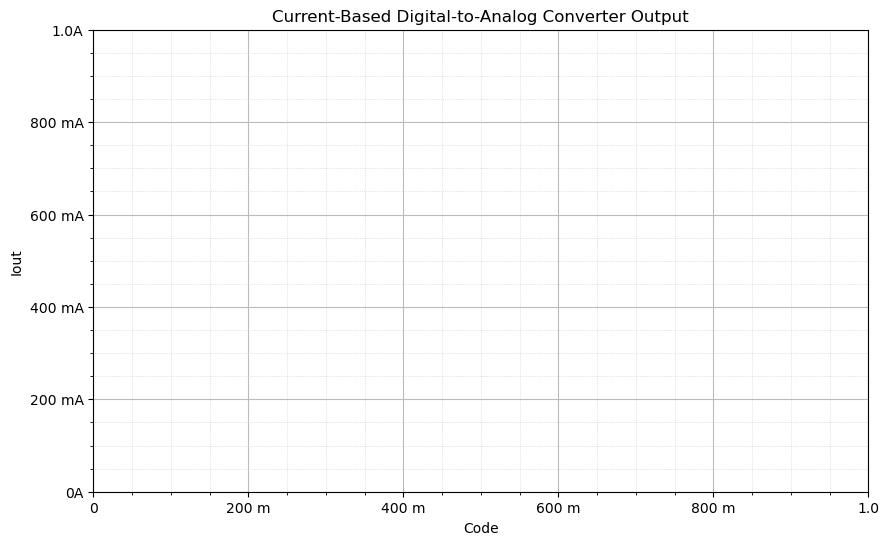

In [5]:
n_codes = 5
mc_simulations = []
results_dir = "current_steering_dac/1/"

for filenum, filename in enumerate(os.listdir(results_dir)):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    print("Raw dataframe:")
    print(df.head(3))
    print()

# yes  code  v(D1)   v(D1b)       i(viin)     i(vidump)
    df.rename({"v(D1)": "vD1", "v(D1b)": "vD1b", "i(viin)": "Iin", "i(vidump)": "Idump"}, axis = "columns", inplace = True)
    df["mc_run"] = filenum

    df.sort_values("code", inplace = True)
    df["diff"] = np.diff(df["Iin"], prepend = 0)
    mc_simulations.append(df)

tdf = (pd.concat(mc_simulations)).sort_values("code")
print("Combined dataframe:")
print(tdf.head(3))
print()

plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "Iin", "A", "Current-Based Digital-to-Analog Converter Output")
mc_helper.make_grids()

Iin_for_max_code = np.mean(tdf["Iin"][tdf["code"] == max(tdf["code"])])
# Iin_for_min_code = np.mean(tdf["Iin"][tdf["code"] == min(tdf["code"])+1])
Iin_for_min_code = 0

lsb = (Iin_for_max_code - Iin_for_min_code) / (n_codes - 1)
tdf["Iin_ideal"] = lsb * tdf["code"] + Iin_for_min_code
tdf["Iin_error"] = tdf["Iin"] - tdf["Iin_ideal"]
max_error = max(tdf["Iin_error"])
tdf["inl"] = tdf["Iin_error"] / lsb
max_inl = max(tdf["inl"])
print(f"lsb = {si_format(lsb, precision = 2)}A")
print(f"max error (INL) = {si_format(max_inl * lsb, precision = 2)}A = {np.round(max_inl, 3)} lsb")

tdf["dnl"] = tdf["diff"] / lsb - 1
tdf["dnl"][tdf["code"] == 0] = 0
max_dnl = max(tdf["dnl"])
print(f"max difference (DNL) = {si_format(max_dnl, precision = 2)}A = {np.round(max_dnl, 3)} lsb")
print()

print("Final dataframe:")
print(tdf.head(3))
print()

for i, df_simulation in enumerate(mc_simulations):
    plt.plot(np.array(tdf["code"]), np.array(tdf["Iin_ideal"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iin"]), c = df_simulation["mc_run"], s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "DNL and INL", " lsb", "DNL and INL")
mc_helper.make_grids()

plt.scatter(tdf["code"], tdf["dnl"], label = "dnl")
plt.scatter(tdf["code"], tdf["inl"], label = "inl")
plt.legend(loc = "lower right")
# plt.xlim(2, 127)
# plt.ylim(-50, 50)